In [2]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 3D problem such as the Navier-Stokes equation discussed in Section 5.3 in the [paper](https://arxiv.org/pdf/2010.08895.pdf),
which takes the 2D spatial + 1D temporal equation directly as a 3D problem
"""


import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from utilities3 import *

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io

torch.manual_seed(0)
np.random.seed(0)


################################################################
# 3d fourier layers
################################################################

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, modes1, modes2, modes3, width):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.fc0 = nn.Linear(13, self.width)
        # input channel is 13: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        batchsize = x.shape[0]
        size_x, size_y, size_z = x.shape[1], x.shape[2], x.shape[3]

        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)

        x1 = self.conv0(x)
        x2 = self.w0(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv1(x)
        x2 = self.w1(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv2(x)
        x2 = self.w2(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2
        x = F.relu(x)
        x1 = self.conv3(x)
        x2 = self.w3(x.view(batchsize, self.width, -1)).view(batchsize, self.width, size_x, size_y, size_z)
        x = x1 + x2

        x = x.permute(0, 2, 3, 4, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

Data: 4D matrix, Nsample * F_grid * $\alpha$ _grid * T _ grid
$\alpha, \rho, \beta, \nu, K, T, F \in(0,1)$

Input: The first 10 time steps

 Output: The last 40 time steps


In [3]:
################################################################
# configs
################################################################

TRAIN_PATH = 'data/SABR3D.mat'
TEST_PATH = 'data/SABR3D.mat'

ntrain = 800
ntest = 200

modes = 8
width = 20

batch_size = 10
batch_size2 = batch_size

epochs = 50
learning_rate = 0.001
scheduler_step = 100
scheduler_gamma = 0.5

print(epochs, learning_rate, scheduler_step, scheduler_gamma)

path = 'test'
# path = 'ns_fourier_V100_N'+str(ntrain)+'_ep' + str(epochs) + '_m' + str(modes) + '_w' + str(width)
path_model = 'model/'+path
path_train_err = 'results/'+path+'train.txt'
path_test_err = 'results/'+path+'test.txt'
path_image = 'image/'+path


runtime = np.zeros(2, )
t1 = default_timer()


sub = 1
S = 50// sub
T_in = 10
T = 40

################################################################
# load data
################################################################

reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain,::sub,::sub,:T_in]
train_u = reader.read_field('u')[:ntrain,::sub,::sub,T_in:T+T_in]

reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:,::sub,::sub,:T_in]
test_u = reader.read_field('u')[-ntest:,::sub,::sub,T_in:T+T_in]

print(train_u.shape)
print(test_u.shape)
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])


a_normalizer = UnitGaussianNormalizer(train_a)
train_a = a_normalizer.encode(train_a)
test_a = a_normalizer.encode(test_a)

y_normalizer = UnitGaussianNormalizer(train_u)
train_u = y_normalizer.encode(train_u)

train_a = train_a.reshape(ntrain,S,S,1,T_in).repeat([1,1,1,T,1])
test_a = test_a.reshape(ntest,S,S,1,T_in).repeat([1,1,1,T,1])

# pad locations (x,y,t)
gridx = torch.tensor(np.linspace(0.1, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1, 1).repeat([1, 1, S, T, 1])
gridy = torch.tensor(np.linspace(0.1, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1, 1).repeat([1, S, 1, T, 1])
gridt = torch.tensor(np.linspace(0, 1, T+1)[1:], dtype=torch.float)
gridt = gridt.reshape(1, 1, 1, T, 1).repeat([1, S, S, 1, 1])

train_a = torch.cat((gridx.repeat([ntrain,1,1,1,1]), gridy.repeat([ntrain,1,1,1,1]),
                       gridt.repeat([ntrain,1,1,1,1]), train_a), dim=-1)
test_a = torch.cat((gridx.repeat([ntest,1,1,1,1]), gridy.repeat([ntest,1,1,1,1]),
                       gridt.repeat([ntest,1,1,1,1]), test_a), dim=-1)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_a, train_u), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=batch_size, shuffle=False)

t2 = default_timer()

print('preprocessing finished, time used:', t2-t1)
device = torch.device('cuda')

50 0.001 100 0.5
torch.Size([800, 50, 50, 40])
torch.Size([200, 50, 50, 40])
preprocessing finished, time used: 9.030827199999976


In [4]:
################################################################
# training and evaluation
################################################################
model = FNO3d(modes, modes, modes, width).cuda()
# model = torch.load('model/ns_fourier_V100_N1000_ep100_m8_w20')

print(count_params(model))
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step, gamma=scheduler_gamma)


myloss = LpLoss(size_average=False)
y_normalizer.cuda()
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).view(batch_size, S, S, T)

        mse = F.mse_loss(out, y, reduction='mean')
        # mse.backward()

        y = y_normalizer.decode(y)
        out = y_normalizer.decode(out)
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()

    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x).view(batch_size, S, S, T)
            out = y_normalizer.decode(out)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

torch.save(model, path_model)


pred = torch.zeros(test_u.shape)
benchmark = torch.zeros(test_u.shape)
inputs = torch.zeros(test_a.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_a, test_u), batch_size=1, shuffle=False)
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x).squeeze()
        out = y_normalizer.decode(out)
        pred[index] = out
        benchmark[index] = y.squeeze()
        inputs[index] = x

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1

scipy.io.savemat('pred/SABR_3d_pred.mat', mdict={'pred': pred.cpu().numpy()})
scipy.io.savemat('pred/SABR_3d_benchmark.mat', mdict={'benchmark': benchmark.cpu().numpy()})
scipy.io.savemat('pred/SABR_3d_inputs.mat', mdict={'inputs': inputs.cpu().numpy()})

3281737
0 17.779539800000066 0.4661859407089651 0.20137348800897598 0.07376100555062294
1 14.837258600000041 0.12348110497696325 0.0634356365352869 0.05448362737894058
2 14.91948750000006 0.07391889059217646 0.04521417710930109 0.050500018745660784
3 15.14233490000015 0.05855765787418932 0.043149896897375584 0.04457435354590416
4 15.08672179999985 0.04584140143415425 0.037319615222513675 0.045298662930727006
5 15.068785799999887 0.037907146115321665 0.03723304577171802 0.037235676869750024
6 14.830850199999986 0.037442588532576336 0.0318719082325697 0.03964572474360466
7 14.719070099999954 0.030986677450709977 0.033851849157363174 0.037750332951545715
8 14.736638099999936 0.026405849534785374 0.035294099189341066 0.031215107440948485
9 14.664803899999924 0.02988728564232588 0.03144523138180375 0.030228100195527078
10 14.714003700000148 0.02662877182010561 0.03260521810501814 0.030264111384749413
11 14.93067370000017 0.020846944260119925 0.030543113835155965 0.026473039463162422
12 14.6

Text(0.5, 0.92, 't=1.6510204081632653')

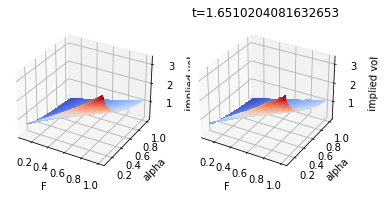

In [26]:
import scipy
import matplotlib.pyplot as plt

pred = scipy.io.loadmat('pred/SABR_3d_pred.mat')
benchmark = scipy.io.loadmat('pred/SABR_3d_benchmark.mat')
predicted = pred['pred']
groundtruth = benchmark['benchmark']

from matplotlib import cm
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
tempx = np.linspace(0.1,2,50)
s = np.linspace(0.1,1,50)
tlist = np.linspace(0.1,2,50)
N = 100
Nt =30
[alphagrid,sgrid] = np.meshgrid(s,s)
fig,(ax1,ax2) = plt.subplots(ncols=2,subplot_kw={"projection": "3d"})
ax1.plot_surface(alphagrid,sgrid,groundtruth[N,:,:,Nt].reshape(50,50),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'groundtruth')
ax1.set_xlabel('F')
ax1.set_ylabel('alpha')
ax1.set_zlabel('implied vol')
ax2.plot_surface(alphagrid,sgrid,predicted[N,:,:,Nt].reshape(50,50),cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,label = 'groundtruth')
ax2.set_xlabel('F')
ax2.set_ylabel('alpha')
ax2.set_zlabel('implied vol')

plt.title('t='+str(tlist[10+Nt]))

In [23]:
import scipy
import matplotlib.pyplot as plt

pred = scipy.io.loadmat('pred/SABR_3d_pred.mat')
benchmark = scipy.io.loadmat('pred/SABR_3d_benchmark.mat')
predicted = pred['pred']
groundtruth = benchmark['benchmark']

from matplotlib import cm
# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
tempx = np.linspace(0.1,2,50)
s = np.linspace(0.1,1,50)
N = 100
for Nt in range(40):
    [alphagrid,sgrid] = np.meshgrid(s,s)

    fig,(ax1,ax2) = plt.subplots(ncols=2,subplot_kw={"projection": "3d"})
    ax1.plot_surface(alphagrid,sgrid,groundtruth[N,:,:,Nt].reshape(50,50),cmap=cm.coolwarm,
                           linewidth=0, antialiased=False,label = 'groundtruth')
    ax1.set_xlabel('F')
    ax1.set_ylabel('alpha')
    ax1.set_zlabel('implied vol')
    ax2.plot_surface(alphagrid,sgrid,predicted[N,:,:,Nt].reshape(50,50),cmap=cm.coolwarm,
                           linewidth=0, antialiased=False,label = 'groundtruth')
    ax2.set_xlabel('F')
    ax2.set_ylabel('alpha')
    ax2.set_zlabel('implied vol')

    plt.savefig('figures/fig_'+str(Nt)+'.png')
    plt.close()


import cv2
import numpy as np
import os
from os.path import isfile, join
import glob
from PIL import Image
#para = 'chicane_r56'
pathIn = 'figures'
fileIn = pathIn + '/' +'*.png'
#pathOut = 'out/video/'+para+'.mp4'

pathOut = pathIn + '/' + 'video.mp4'
gifOut = pathIn+'/'+'video.gif'
fps = 1
frame_array = []

files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f)) and (pathIn+'\\'+f) in glob.glob(fileIn)]
#bbfiles = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
# for sorting the file names properly
#files.sort(key=lambda x: x[5:-4])
#files.sort()
#frame_array = []
#files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
# for sorting the file names properly
#files.sort(key=lambda x: x[5:-4])
for i in range(len(files)):
    filename = pathIn + '/'+files[i]
    # reading each files
    img = cv2.imread(filename)

    if i ==0:
        height, width, layers = img.shape
        size = (width, height)

    resized = cv2.resize(img, size)
    # inserting the frames into an image array
    frame_array.append(resized)


out = cv2.VideoWriter(pathOut, cv2.VideoWriter_fourcc(*'DIVX'), fps,size)
for i in range(len(frame_array)):
    print(i)
    # writing to a image array
    out.write(frame_array[i])
out.release()

# make gif
img, *imgs = [Image.open(f) for f in glob.glob(fileIn)]
img.save(fp=gifOut, format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
